In [1]:
import gensim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from keras.applications import VGG16
from keras.models import Model
from keras.applications.vgg16 import preprocess_input
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.utils import to_categorical
import os
import missingno as msno
import cv2

os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'


In [2]:
df = pd.read_csv('flipkart.csv')

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

 ## image
 

In [43]:
# Création d'une nouvelle colonne "product_category" dans le DataFrame
df['product_category'] = df['product_category_tree'].apply(lambda x: x.split('>>')[0].strip())

df['product_category'] = df['product_category'].str.replace(r'\[', '', regex=True).str.replace('"', '', regex=True)

# Affichage des 7 catégories différentes
df['product_category'].unique()


array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [44]:
df['product_category'].value_counts()

product_category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

In [24]:
df

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,description_processing,product_name_processing,product_category
0,009099b1f6e1e8f893ec29a7023153c4,2016-04-24 18:34:50 +0000,http://www.flipkart.com/palito-plo-166-analog-...,"palito PLO 166 Analog Watch - For Girls, Women","[""Watches >> Wrist Watches >> palito Wrist Wat...",WATEHZPFAPQKUASQ,1500.0,199.0,009099b1f6e1e8f893ec29a7023153c4.jpg,False,Specifications of palito PLO 166 Analog Watch ...,No rating available,No rating available,palito,"{""product_specification""=>[{""key""=>""Type"", ""va...",specif palito plo 166 analog watch girl women ...,palito plo 166 analog watch girl women,Watches
1,0096e89cc25a8b96fb9808716406fe94,2016-06-17 14:13:36 +0000,http://www.flipkart.com/oxford-tawa-15-cm-diam...,oxford Tawa 15 cm cm diameter,"[""Kitchen & Dining >> Cookware >> Pots & Pans ...",PTPEJQR9VKFUV4HY,699.0,659.0,0096e89cc25a8b96fb9808716406fe94.jpg,False,Key Features of oxford Tawa 15 cm cm diameter ...,No rating available,No rating available,oxford,"{""product_specification""=>[{""key""=>""Pan Type"",...",key featur oxford tawa 15 cm cm diamet nonstic...,oxford tawa 15 cm cm diamet,Kitchen & Dining
2,00cbbc837d340fa163d11e169fbdb952,2016-01-01 19:37:22 +0000,http://www.flipkart.com/flazee-home-trends-bei...,Flazee Home Trends Beige 144.78 cm Table Runner,"[""Home Furnishing >> Kitchen & Dining Linen >>...",TBRE8GR3RSTQTXMJ,1299.0,399.0,00cbbc837d340fa163d11e169fbdb952.jpg,False,Buy Flazee Home Trends Beige 144.78 cm Table R...,No rating available,No rating available,Flazee Home Trends,"{""product_specification""=>[{""key""=>""Shape"", ""v...",buy flaze home trend beig 14478 cm tabl runner...,flaze home trend beig 14478 cm tabl runner,Home Furnishing
3,00d84a518e0550612fcfcba3b02b6255,2015-12-12 11:46:53 +0000,http://www.flipkart.com/mxofere-combo-rose-soa...,Mxofere Combo Rose Soap And Aloevera Lemon Fac...,"[""Beauty and Personal Care >> Combos and Kits ...",CBKEBVA8PUFUPRW4,285.0,285.0,00d84a518e0550612fcfcba3b02b6255.jpg,False,Buy Mxofere Combo Rose Soap And Aloevera Lemon...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Organic Ty...",buy mxofer combo rose soap aloevera lemon face...,mxofer combo rose soap aloevera lemon facewash...,Beauty and Personal Care
4,00e966a5049a262cfc72e6bbf68b80e7,2016-06-17 07:53:02 +0000,http://www.flipkart.com/ygs-keyboard-case-asus...,YGS Keyboard Case for Asus Memo Pad 7in Tab,"[""Computers >> Tablet Accessories >> Cases & C...",ACCEJGH6JVTM4CBH,1000.0,499.0,00e966a5049a262cfc72e6bbf68b80e7.jpg,False,Key Features of YGS Keyboard Case for Asus Mem...,No rating available,No rating available,YGS,"{""product_specification""=>[{""key""=>""Brand"", ""v...",key featur yg keyboard case asu memo pad 7in t...,yg keyboard case asu memo pad 7in tab,Computers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,feefbdff924dd6b7cc266449c9a36d69,2015-12-01 12:40:44 +0000,http://www.flipkart.com/rockmantra-red-flowers...,Rockmantra Red Flowers In Bucket Ceramic Mug,"[""Kitchen & Dining >> Coffee Mugs >> Rockmantr...",MUGEAGGKMUGXQ2YH,499.0,199.0,feefbdff924dd6b7cc266449c9a36d69.jpg,False,Rockmantra Red Flowers In Bucket Ceramic Mug (...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Type"", ""va...",rockmantra red flower bucket ceram mug 55 l pr...,rockmantra red flower bucket ceram mug,Kitchen & Dining
1046,ff24511994fc459d04145231c8876d6c,2016-01-01 19:37:22 +0000,http://www.flipkart.com/home-originals-polka-a...,"Home Originals Polka, Abstract Double Blanket ...","[""Home Furnishing >> Bed Linen >> Blankets, Qu...",BLAEE2GJYAAQRHK8,2999.0,1299.0,ff24511994fc459d04145231c8876d6c.jpg,False,"Buy Home Originals Polka, Abstract Double Blan...",No rating available,No rating available,Home Originals

In [14]:
df.describe()

,retail_price,discounted_price
count,1049.000000,1049.000000
mean,2186.197331,1584.527169
std,7639.229411,7475.099680
min,35.000000,35.000000
25%,555.000000,340.000000
50%,999.000000,600.000000
75%,1999.000000,1199.000000
max,201000.000000,201000.000000


<Axes: >

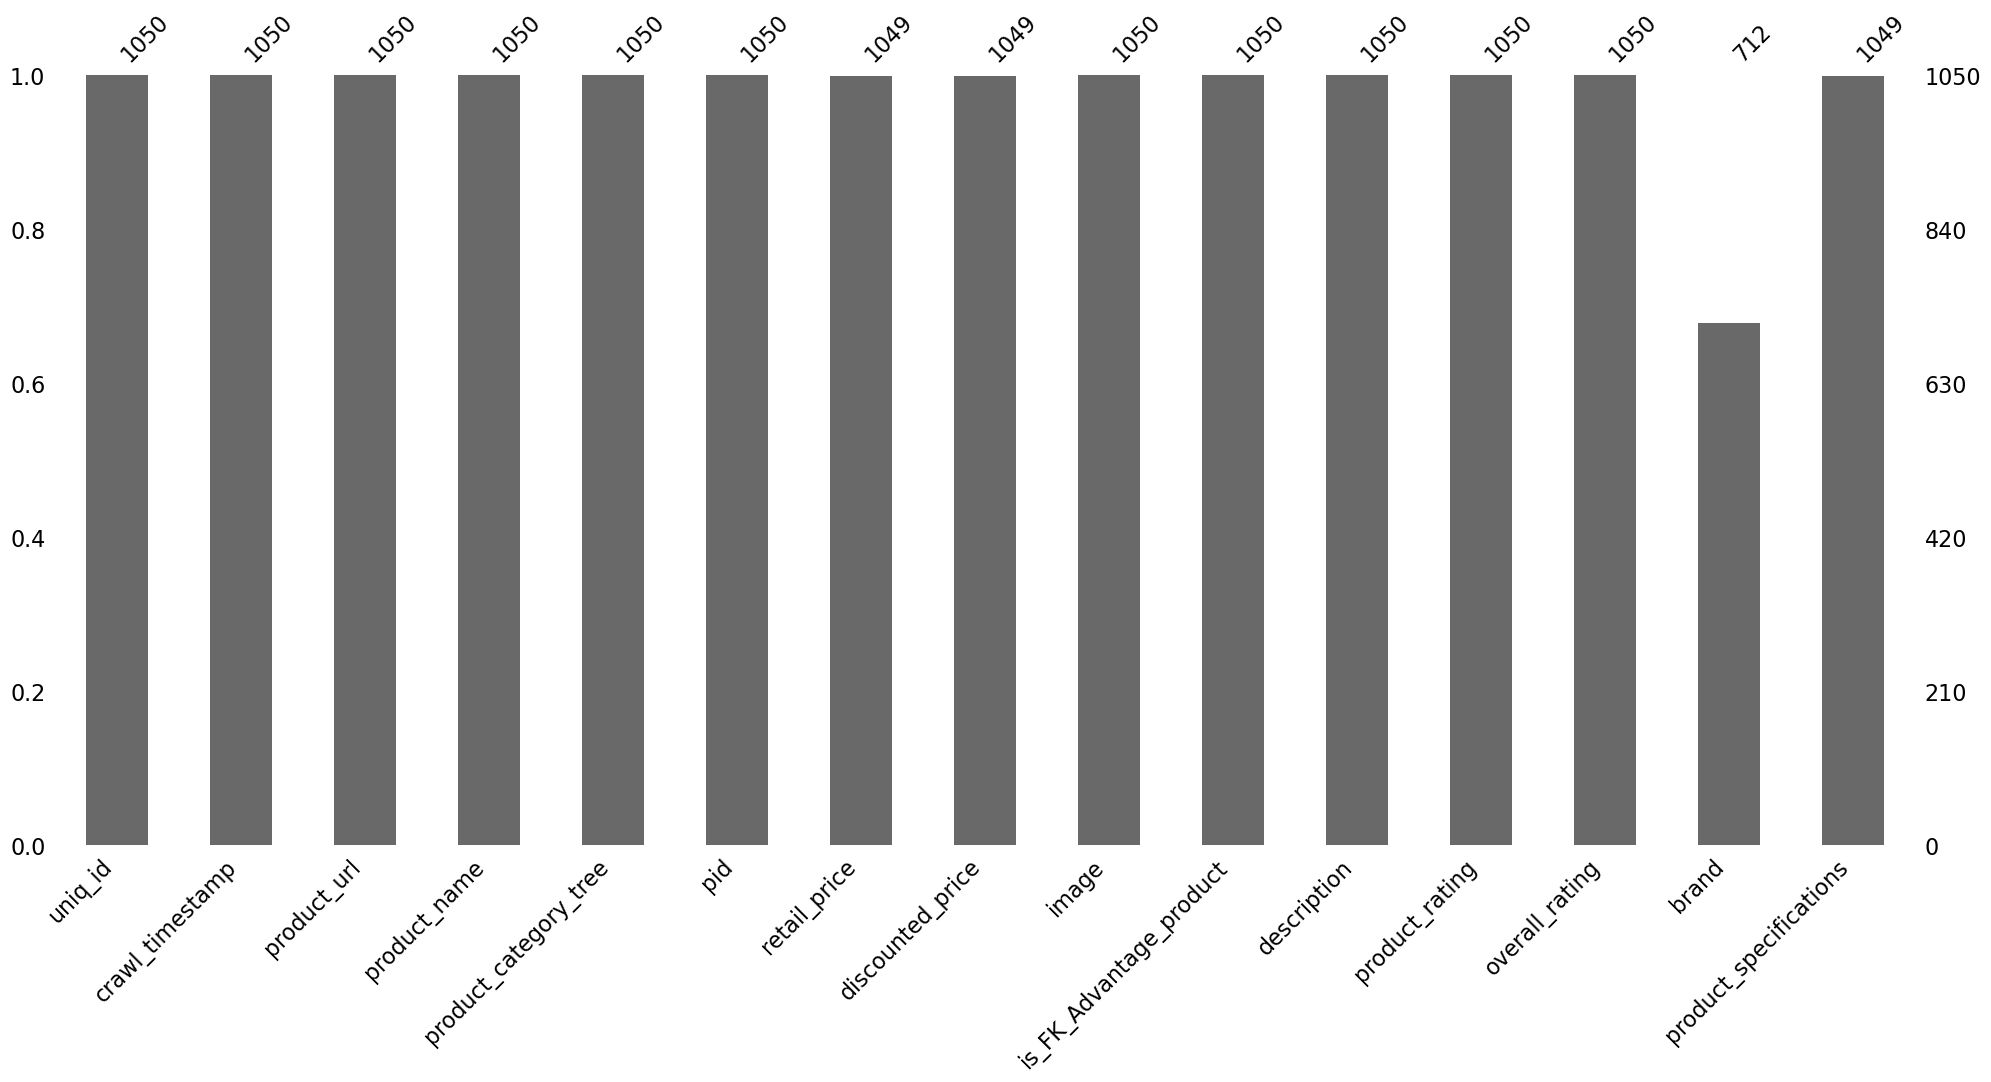

In [6]:
msno.bar(df)

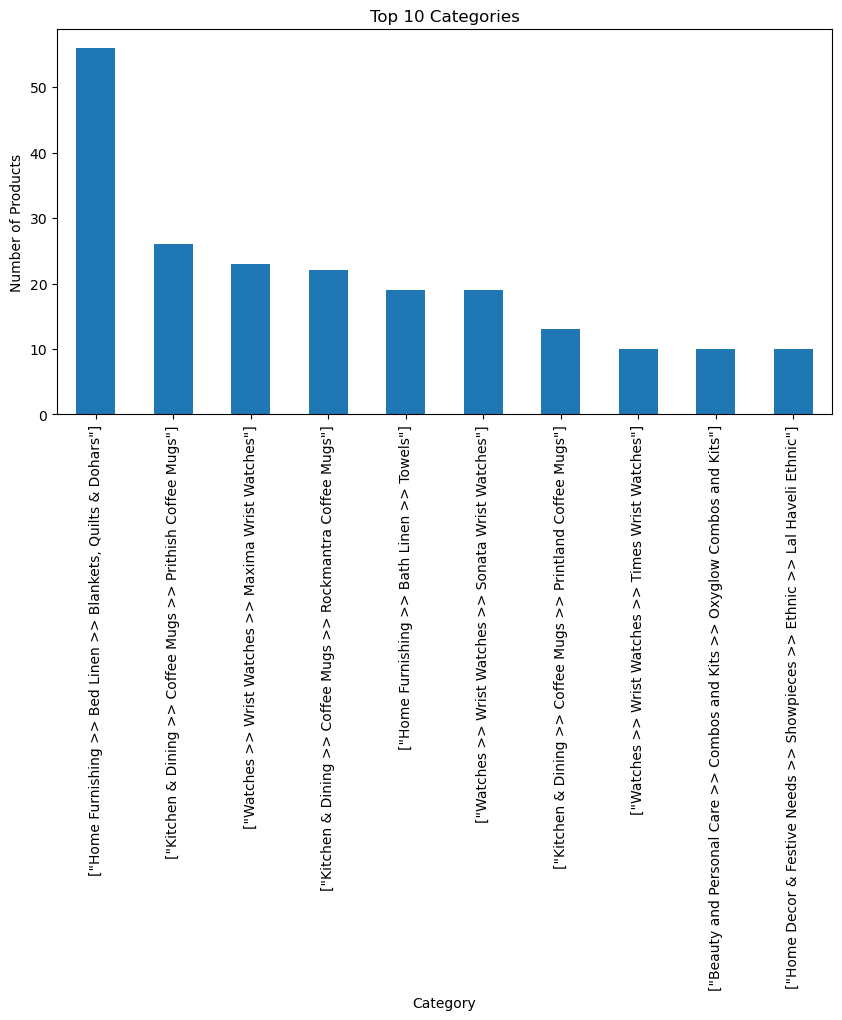

In [7]:
df['product_category_tree'].value_counts().head(10).plot(kind='bar', figsize=(10,5))
plt.title('Top 10 Categories')
plt.xlabel('Category')
plt.ylabel('Number of Products')
plt.show()


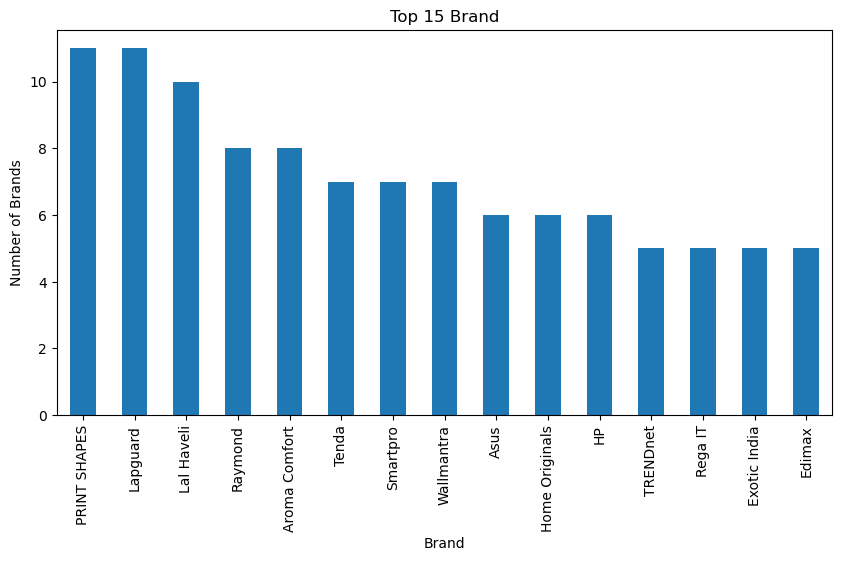

In [9]:
df['brand'].value_counts().head(15).plot(kind='bar', figsize=(10,5))
plt.title('Top 15 Brand')
plt.xlabel('Brand')
plt.ylabel('Number of Brands')
plt.show()


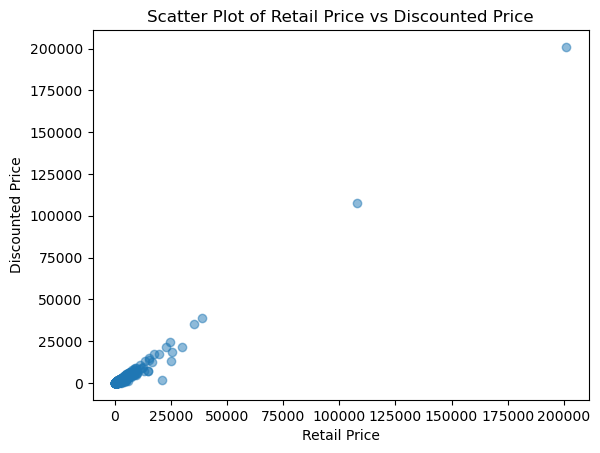

In [9]:

plt.scatter(df['retail_price'], df['discounted_price'], alpha=0.5)
plt.xlabel('Retail Price')
plt.ylabel('Discounted Price')
plt.title('Scatter Plot of Retail Price vs Discounted Price')
plt.show()



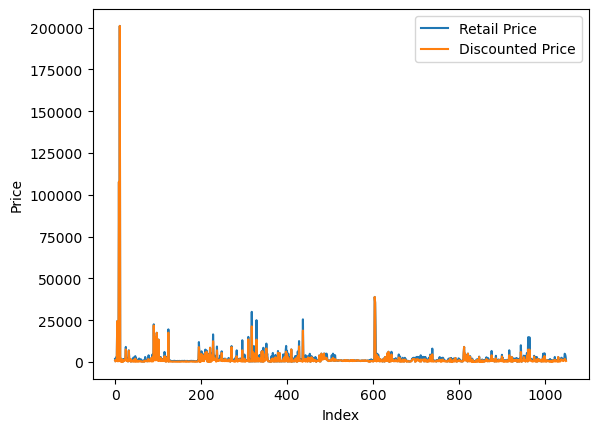

In [10]:
plt.plot(df['retail_price'], label='Retail Price')
plt.plot(df['discounted_price'], label='Discounted Price')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.show()

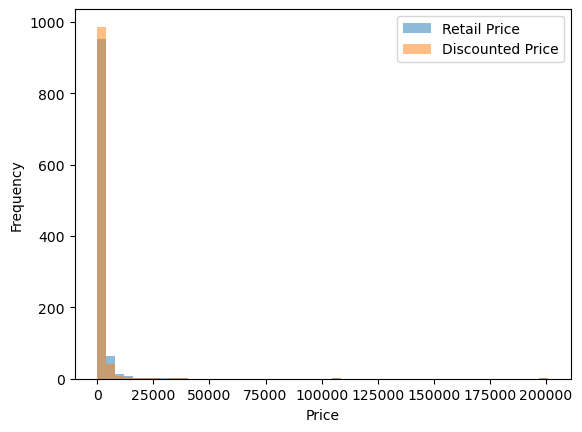

In [11]:
plt.hist(df['retail_price'], bins=50, alpha=0.5, label='Retail Price')
plt.hist(df['discounted_price'], bins=50, alpha=0.5, label='Discounted Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [45]:
df

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,description_processing,product_name_processing,product_category
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,009099b1f6e1e8f893ec29a7023153c4.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",key featur eleg polyest multicolor abstract ey...,eleg polyest multicolor abstract eyelet door c...,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,0096e89cc25a8b96fb9808716406fe94.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",specif sathiya cotton bath towel 3 bath towel ...,sathiya cotton bath towel,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,00cbbc837d340fa163d11e169fbdb952.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",key featur eurospa cotton terri face towel set...,eurospa cotton terri face towel set,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,00d84a518e0550612fcfcba3b02b6255.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",key featur santosh royal fashion cotton print ...,santosh royal fashion cotton print king size d...,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,00e966a5049a262cfc72e6bbf68b80e7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",key featur jaipur print cotton floral king siz...,jaipur print cotton floral king size doubl bed...,Home Furnishing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,feefbdff924dd6b7cc266449c9a36d69.jpg,False,Oren Empower Extra Large Self Adhesive Sticker...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ...",oren empow extra larg self adhes sticker pack ...,oren empow extra larg self adhes sticker,Baby Care
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZD5GDCVQ,4930.0,1896.0,ff24511994fc459d04145231c8876d6c.jpg,False,Wallmantra Large Vinyl Sticker Sticker (Pack o...,No rating available,No rating available,Wallmantra,

In [3]:
# Fonction de prétraitement
def preprocess(text):
    # Conversion en minuscules
    text = text.lower()
    # Suppression de la ponctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenisation
    words = word_tokenize(text)
    # Suppression des stopwords
    words = [w for w in words if w not in stopwords.words('english')]
    # Stemmatisation
    stemmer = PorterStemmer()
    words = [stemmer.stem(w) for w in words]
    # Reconstruction du texte
    text = ' '.join(words)
    return text

# Application de la fonction de prétraitement à la colonne "description"
df[['description_processing','product_name_processing']] = df[['description','product_name']].applymap(preprocess)


In [10]:
df_bert =  df.copy()

In [11]:
# Fonction de prétraitement
def preprocessBert(text):
    # Conversion en minuscules
    text = text.lower()
    # Suppression de la ponctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenisation
    words = word_tokenize(text)
    # Suppression des stopwords
    #words = [w for w in words if w not in stopwords.words('english')]
    # Stemmatisation
    #stemmer = PorterStemmer()
    #words = [stemmer.stem(w) for w in words]
    # Reconstruction du texte
    text = ' '.join(words)
    return text

# Application de la fonction de prétraitement à la colonne "description"
df_bert[['description_processing','product_name_processing']] = df[['description','product_name']].applymap(preprocessBert)

In [12]:
df[['description', 'description_processing','product_name_processing','product_name']].head(10)

,description,description_processing,product_name_processing,product_name
0,Specifications of palito PLO 166 Analog Watch ...,specif palito plo 166 analog watch girl women ...,palito plo 166 analog watch girl women,"palito PLO 166 Analog Watch - For Girls, Women"
1,Key Features of oxford Tawa 15 cm cm diameter ...,key featur oxford tawa 15 cm cm diamet nonstic...,oxford tawa 15 cm cm diamet,oxford Tawa 15 cm cm diameter
2,Buy Flazee Home Trends Beige 144.78 cm Table R...,buy flaze home trend beig 14478 cm tabl runner...,flaze home trend beig 14478 cm tabl runner,Flazee Home Trends Beige 144.78 cm Table Runner
3,Buy Mxofere Combo Rose Soap And Aloevera Lemon...,buy mxofer combo rose soap aloevera lemon face...,mxofer combo rose soap aloevera lemon facewash...,Mxofere Combo Rose Soap And Aloevera Lemon Fac...
4,Key Features of YGS Keyboard Case for Asus Mem...,key featur yg keyboard case asu memo pad 7in t...,yg keyboard case asu memo pad 7in tab,YGS Keyboard Case for Asus Memo Pad 7in Tab
5,Buy Crystle Crystle01 CRSTL - Bluecensor USB L...,buy crystl crystle01 crstl bluecensor usb led ...,crystl crystle01 crstl bluecensor usb led ligh...,Crystle Crystle01 CRSTL - Bluecensor USB Led L...
6,Buy KLIQVIK SIX PORT USB HUB FOR I PHONE 4 MOB...,buy kliqvik six port usb hub phone 4 mobil tr2...,kliqvik six port usb hub phone 4 mobil tr256 u...,KLIQVIK SIX PORT USB HUB FOR I PHONE 4 MOBILES...
7,Buy Sumeet Hard Anodised 14 Kadhai 3 L for Rs....,buy sumeet hard anodis 14 kadhai 3 l rs1045 on...,sumeet hard anodis 14 kadhai 3 l,Sumeet Hard Anodised 14 Kadhai 3 L
8,Buy Oxyglow Fruit Massage Cream With Vitamin-E...,buy oxyglow fruit massag cream vitamin gold fa...,oxyglow fruit massag cream vitamin gold facial...,Oxyglow Fruit Massage Cream With Vitamin-E & G...
9,Prithish Believe In Yourself Double Color Cera...,prithish believ doubl color ceram mug 330 ml p...,prithish believ doubl color ceram mug,Prithish Believe In Yourself Double Color Cera...


In [13]:
df_bert[['description_processing','product_name_processing']]

,description_processing,product_name_processing
0,specifications of palito plo 166 analog watch ...,palito plo 166 analog watch for girls women
1,key features of oxford tawa 15 cm cm diameter ...,oxford tawa 15 cm cm diameter
2,buy flazee home trends beige 14478 cm table ru...,flazee home trends beige 14478 cm table runner
3,buy mxofere combo rose soap and aloevera lemon...,mxofere combo rose soap and aloevera lemon fac...
4,key features of ygs keyboard case for asus mem...,ygs keyboard case for asus memo pad 7in tab
...,...,...
1045,rockmantra red flowers in bucket ceramic mug 5...,rockmantra red flowers in bucket ceramic mug
1046,buy home originals polka abstract double blank...,home originals polka abstract double blanket m...
1047,buy returnfavors cartoon shaped coffee for kid...,returnfavors cartoon shaped coffee for kids ce...
1048,buy raymond abstract double blanket grey at rs...,raymond abstract double blanket grey


In [11]:
df

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,description_processing,product_name_processing
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",key featur eleg polyest multicolor abstract ey...,eleg polyest multicolor abstract eyelet door c...
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",specif sathiya cotton bath towel 3 bath towel ...,sathiya cotton bath towel
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",key featur eurospa cotton terri face towel set...,eurospa cotton terri face towel set
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",key featur santosh royal fashion cotton print ...,santosh royal fashion cotton print king size d...
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",key featur jaipur print cotton floral king siz...,jaipur print cotton floral king size doubl bed...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,Oren Empower Extra Large Self Adhesive Sticker...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ...",oren empow extra larg self adhes sticker pack ...,oren empow extra larg self adhes sticker
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZD5GDCVQ,4930.0,1896.0,fd6cbcc22efb6b761bd564c28928483c.jpg,False,Wallmantra Large Vinyl Sticker Sticker (Pack o...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ...",wallmantra larg vinyl sticker sticker pack

## Extraction features

In [4]:
nltk.download('punkt')
from nltk import FreqDist


# Définition des paramètres de TfidfVectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5)

# Combinaison des colonnes "description_processing" et "product_name_processing"
corpus = (df['description_processing'] + ' ' + df['product_name_processing']).values.astype('U')

# Tokenisation du corpus
corpus_tokenized = [word_tokenize(text) for text in corpus]


# Transformation du corpus tokenisé en vecteurs tf-idf
X = vectorizer.fit_transform([' '.join(tokens) for tokens in corpus_tokenized])
#vect_name = vectorizer.get_feature_names_out()



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sylvain\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


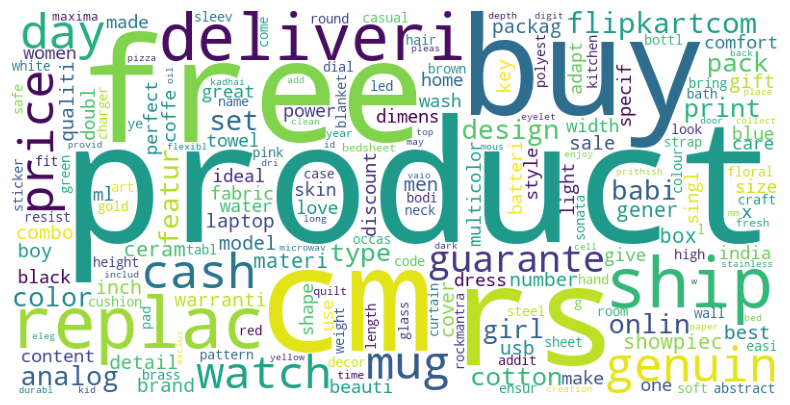

In [5]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white', collocations=False).generate(' '.join(corpus))
# 'collocations=False' est utilisé pour exclure les bigrammes
# Affichage du wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()



In [6]:
import nltk
from nltk import FreqDist

# Tokenisation du corpus
corpus_tokenized = [nltk.word_tokenize(text) for text in corpus]

# Calcul de la fréquence des tokens
token_freq = FreqDist([token for tokens in corpus_tokenized for token in tokens])


In [7]:
most_common_tokens = token_freq.most_common(20)
for token, freq in most_common_tokens:
    print(token, freq)


product 869
cm 648
free 616
rs 595
buy 582
replac 579
ship 570
deliveri 567
genuin 564
cash 564
price 557
day 555
mug 525
watch 511
30 495
guarante 473
flipkartcom 472
set 447
1 433
design 416


In [51]:
print(len(corpus_tokenized))

1050


In [52]:
corpus_tokenized

[['key',
  'featur',
  'eleg',
  'polyest',
  'multicolor',
  'abstract',
  'eyelet',
  'door',
  'curtain',
  'floral',
  'curtaineleg',
  'polyest',
  'multicolor',
  'abstract',
  'eyelet',
  'door',
  'curtain',
  '213',
  'cm',
  'height',
  'pack',
  '2',
  'price',
  'rs',
  '899',
  'curtain',
  'enhanc',
  'look',
  'interiorsthi',
  'curtain',
  'made',
  '100',
  'high',
  'qualiti',
  'polyest',
  'fabricit',
  'featur',
  'eyelet',
  'style',
  'stitch',
  'metal',
  'ringit',
  'make',
  'room',
  'environ',
  'romant',
  'lovingthi',
  'curtain',
  'ant',
  'wrinkl',
  'anti',
  'shrinkag',
  'eleg',
  'apparanceg',
  'home',
  'bright',
  'modernist',
  'appeal',
  'design',
  'surreal',
  'attent',
  'sure',
  'steal',
  'heart',
  'contemporari',
  'eyelet',
  'valanc',
  'curtain',
  'slide',
  'smoothli',
  'draw',
  'apart',
  'first',
  'thing',
  'morn',
  'welcom',
  'bright',
  'sun',
  'ray',
  'want',
  'wish',
  'good',
  'morn',
  'whole',
  'world',
  'dra

In [53]:
# Affichage des dimensions de la matrice
print(X.shape) # vérifier que la taille de la matrice a bien changé

(1050, 1011)


In [54]:
x_Tfid = X.toarray()


In [55]:
(df['description_processing'] + " " + df['product_name_processing']).iloc[0]

'key featur eleg polyest multicolor abstract eyelet door curtain floral curtaineleg polyest multicolor abstract eyelet door curtain 213 cm height pack 2 price rs 899 curtain enhanc look interiorsthi curtain made 100 high qualiti polyest fabricit featur eyelet style stitch metal ringit make room environ romant lovingthi curtain ant wrinkl anti shrinkag eleg apparanceg home bright modernist appeal design surreal attent sure steal heart contemporari eyelet valanc curtain slide smoothli draw apart first thing morn welcom bright sun ray want wish good morn whole world draw close even creat special moment joyou beauti given sooth print bring home eleg curtain softli filter light room get right amount sunlightspecif eleg polyest multicolor abstract eyelet door curtain 213 cm height pack 2 gener brand eleg design door type eyelet model name abstract polyest door curtain set 2 model id duster25 color multicolor dimens length 213 cm box number content sale packag pack 2 sale packag 2 curtain bod

In [56]:

# Réduction de dimension avec une ACP
pca = PCA()
X_pca = pca.fit_transform(x_Tfid)

# Réduction de dimension avec t-SNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_pca)



In [57]:
from sklearn.cluster import KMeans

for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=1, n_init='auto').fit(X_tsne)

    print("Nombre de clusters : {} ; Inertie : {:.2f}".format(n_clusters, kmeans.inertia_))

Nombre de clusters : 1 ; Inertie : 1104569.00
Nombre de clusters : 2 ; Inertie : 666778.06
Nombre de clusters : 3 ; Inertie : 408225.31
Nombre de clusters : 4 ; Inertie : 261075.09
Nombre de clusters : 5 ; Inertie : 194499.89
Nombre de clusters : 6 ; Inertie : 153281.84
Nombre de clusters : 7 ; Inertie : 115079.91
Nombre de clusters : 8 ; Inertie : 96824.98
Nombre de clusters : 9 ; Inertie : 80651.84
Nombre de clusters : 10 ; Inertie : 70815.74


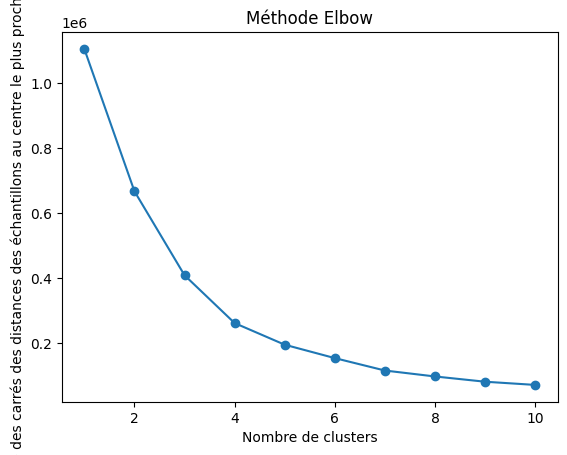

In [58]:
inertias = []

for n_clusters in range(1, 11):
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=1, n_init='auto').fit(X_tsne)

    inertias.append(kmeans.inertia_)

plt.plot(range(1, 11), inertias, marker='o')
plt.title('Méthode Elbow')
plt.xlabel('Nombre de clusters')
plt.ylabel("Somme des carrés des distances des échantillons au centre le plus proche (inertie)")
plt.show()


In [59]:
from sklearn.metrics import silhouette_score
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=1, n_init='auto').fit(X_tsne)
    labels = kmeans.labels_
    score = silhouette_score(X_tsne, labels)
    print(f"Silhouette score for {n_clusters} clusters: {score}")

Silhouette score for 2 clusters: 0.3648156523704529
Silhouette score for 3 clusters: 0.40321242809295654
Silhouette score for 4 clusters: 0.45510631799697876
Silhouette score for 5 clusters: 0.44960322976112366
Silhouette score for 6 clusters: 0.4708397388458252
Silhouette score for 7 clusters: 0.5000956058502197
Silhouette score for 8 clusters: 0.5060631632804871
Silhouette score for 9 clusters: 0.5015278458595276
Silhouette score for 10 clusters: 0.5069975256919861


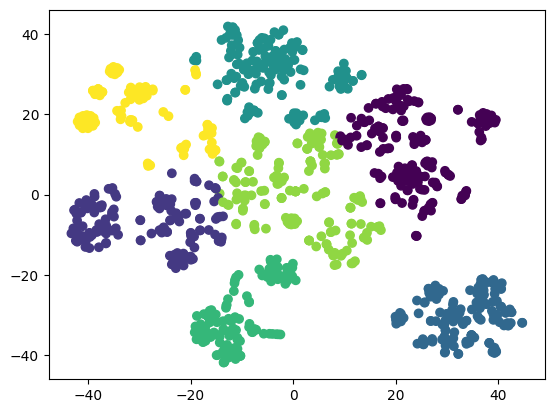

In [60]:
# Clustering avec k-means
kmeans = KMeans(n_clusters=7, random_state=0,n_init='auto').fit(X_tsne)


# Affichage des clusters
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=kmeans.labels_)
plt.show()


In [61]:
#utiliser product category three
from sklearn.metrics import adjusted_rand_score

# On suppose que "y_true" est un vecteur contenant les labels réels et "y_pred" les labels prédits par votre modèle de clustering KMeans
y_true = df['product_category'].values
y_pred = kmeans.labels_

# Calcul de l'ARI
ari = adjusted_rand_score(y_true, y_pred)

# Affichage de l'ARI
print("ARI:", ari)



ARI: 0.5106877714850495


## Word2Vec

In [62]:
import time
from sklearn import manifold, decomposition
from sklearn import cluster, metrics

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=7, n_init=100, random_state=42)
    cls.fit(X_tsne)
    y_true = df['product_category'].values
    y_pred = kmeans.labels_

    # Calcul de l'ARI
    ari = adjusted_rand_score(y_true, y_pred)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ari, "time : ", time2)
    
    return ari, X_tsne, cls.labels_

In [73]:
# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, labels, ari) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des categories de produit par clusters')
    
    plt.show()
    print("ARI : ", ari)

In [64]:

import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model


In [65]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences

In [66]:
from gensim.models import Word2Vec
print("Build & train Word2Vec model ...")

# Entraîner le modèle Word2Vec
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)

w2v_model.build_vocab(corpus_tokenized)
w2v_model.train(corpus_tokenized,total_examples=w2v_model.corpus_count, epochs=100)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 5593
Word2Vec trained


In [67]:
print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus_tokenized)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(corpus_tokenized),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 5594


In [68]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (5594, 300)


In [69]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 24, 300)           1678200   
                                                                 
 global_average_pooling1d_1   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 1,678,200
Trainable params: 1,678,200
Non-trainable params: 0
_________________________________________________________________


In [70]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 1ms/step


(1050, 300)

In [71]:
ari, X_tsne, labels = ARI_fct(embeddings)

ARI :  0.5106877714850495 time :  12.0


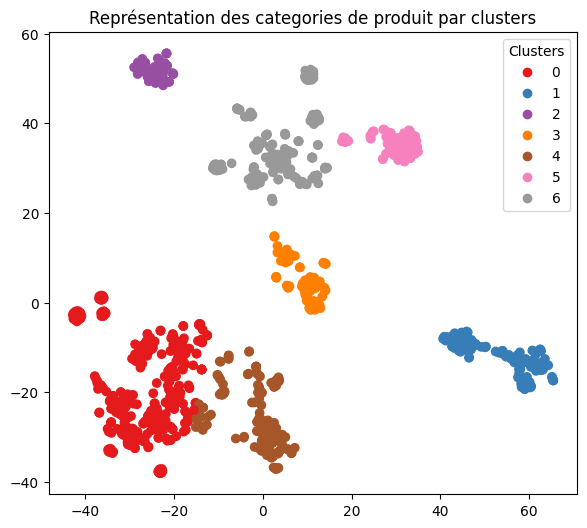

ARI :  0.5106877714850495


In [74]:
TSNE_visu_fct(X_tsne, labels, ari)

## Use

In [3]:
import tensorflow_hub as hub

# Charger le modèle USE
model_use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")


In [8]:
embeddings = model_use(corpus)

In [10]:
from sklearn.preprocessing import StandardScaler

# Normalisation des vecteurs
scaler = StandardScaler()
X_scaled = scaler.fit_transform(embeddings.numpy())



In [11]:
# Réduction de dimension avec une ACP
pca = PCA()
X_pca = pca.fit_transform(X_scaled)



In [12]:
# Réduction de dimension avec t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_pca)



In [17]:
from sklearn.metrics import adjusted_rand_score

# Clustering avec k-means
kmeans = KMeans(n_clusters=7, random_state=0, n_init='auto').fit(X_tsne)

# On suppose que "y_true" est un vecteur contenant les labels réels et "y_pred" les labels prédits par votre modèle de clustering KMeans
y_true = df['product_category'].values
y_pred = kmeans.predict(X_tsne)

# Calcul de l'ARI
ari = adjusted_rand_score(y_true, y_pred)

# Affichage de l'ARI
print("ARI:", ari)

ARI: 0.42242158429137555


In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
#from wordcloud import WordCloud
nltk.download('punkt')
from nltk.tokenize import word_tokenize


# Définition des paramètres de TfidfVectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.7)

# Combinaison des colonnes "description_processing" et "product_name_processing"
corpus_bert = (df_bert['description_processing'] + ' ' + df_bert['product_name_processing']).values.astype('U')

# Tokenisation du corpus
corpus_tokenized_b = [word_tokenize(text) for text in corpus_bert]

#wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(' '.join(corpus))

# Transformation du corpus tokenisé en vecteurs tf-idf
X = vectorizer.fit_transform([' '.join(tokens) for tokens in corpus_tokenized_b])
#vect_name = vectorizer.get_feature_names_out()

# Affichage des dimensions de la matrice
#print(X.shape) # vérifier que la taille de la matrice a bien changé
# Affichage du wordcloud
#plt.figure(figsize=(10, 5))
#plt.imshow(wordcloud, interpolation='bilinear')
#plt.axis('off')
#plt.show()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sylvain\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Bert

In [41]:
corpus_bert = (df_bert['description_processing'] + ' ' + df_bert['product_name_processing']).values.astype('U')

In [42]:
# Création d'une nouvelle colonne "product_category" dans le DataFrame
df_bert['product_category'] = df_bert['product_category_tree'].apply(lambda x: x.split('>>')[0].strip())

In [51]:
# Création d'une nouvelle colonne "product_category" dans le DataFrame
df_bert['product_category'] = df_bert['product_category_tree'].apply(lambda x: x.split('>>')[0].strip())

# Affichage des 7 catégories différentes
df_bert['product_category'].unique()


array(['["Home Furnishing', '["Baby Care', '["Watches',
       '["Home Decor & Festive Needs', '["Kitchen & Dining',
       '["Beauty and Personal Care', '["Computers'], dtype=object)

In [53]:


df_bert['product_category'] = df_bert['product_category'].str.replace('\[', '', regex=True).str.replace('"', '', regex=True)

df_bert['product_category'].value_counts()


product_category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

In [44]:
from sentence_transformers import SentenceTransformer, util

# Charger le modèle BERT
model = SentenceTransformer('multi-qa-distilbert-cos-v1')

C:\Users\Sylvain\anaconda3\envs\classification\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [45]:
# Encoder les phrases du corpus avec le modèle BERT ne pas encoder des token mais des phrases utilise corpus
corpus_embeddings = model.encode(corpus_bert)

In [46]:
pca = PCA()
pca_embeddings = pca.fit_transform(corpus_embeddings)

In [47]:
tsne = TSNE(n_components=2)
tsne_embeddings = tsne.fit_transform(pca_embeddings)

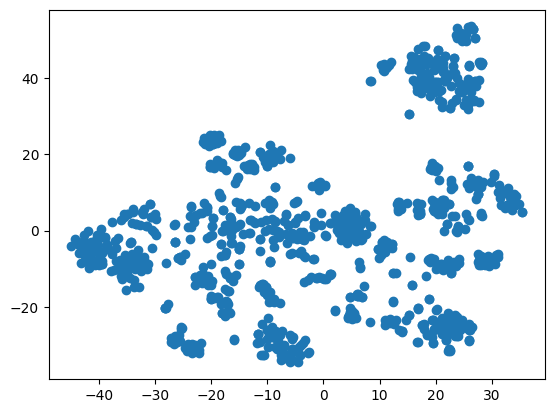

In [48]:
# Visualiser les embeddings t-SNE
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1])
plt.show()

In [49]:
from sklearn.metrics import adjusted_rand_score

# Clustering avec k-means
kmeans = KMeans(n_clusters=7, random_state=0, n_init='auto').fit(tsne_embeddings)

# On suppose que "y_true" est un vecteur contenant les labels réels et "y_pred" les labels prédits par votre modèle de clustering KMeans
y_true = df_bert['product_category'].values
y_pred = kmeans.predict(tsne_embeddings)

# Calcul de l'ARI
ari = adjusted_rand_score(y_true, y_pred)

# Affichage de l'ARI
print("ARI:", ari)

ARI: 0.6315954451371194


## Prétraitement Image

In [8]:
#Faire étape par etape du prepross
import os
from PIL import Image, ImageOps, ImageFilter

# Chemin vers le dossier contenant les images originales
input_path = "Images/"

# Chemin vers le dossier de sortie pour les images modifiées
output_path = "imageModif/"

# Créer le dossier de sortie s'il n'existe pas déjà
if not os.path.exists(output_path):
    os.mkdir(output_path)

# Parcourir tous les fichiers du dossier d'entrée
for filename in os.listdir(input_path):
    if filename.endswith(".jpg"):
        # Ouvrir l'image et appliquer les traitements
        with Image.open(os.path.join(input_path, filename)) as img:
            img = img.convert('L')  # Noir & Blanc
            img = ImageOps.equalize(img)  # Égalisateur histogramme
            img = img.filter(ImageFilter.GaussianBlur(radius=2))  # Filtre gaussien

            # Sauvegarder l'image modifiée dans le dossier de sortie
            output_file = os.path.join(output_path, filename)
            img.save(output_file)


In [52]:
from PIL import Image, ImageOps, ImageFilter
# Charger l'image
img = Image.open("Images/c4ac93e194281d6d1450ffdaa52f5f99.jpg")
output_path = "imagePres/output.jpg"

# Convertir l'image en noir et blanc
img = img.convert('L')

# Enregistrer l'image résultante en noir et blanc
img.save(output_path)

# Vérifier l'extension du fichier
if output_path.endswith(".jpg"):
    print("L'image a été enregistrée au format JPG.")


L'image a été enregistrée au format JPG.


In [53]:


# Charger l'image 
img = Image.open("imagePres/output.jpg")
output_path = "imagePres/outblur.jpg"

# Appliquer un filtre gaussien
img = img.filter(ImageFilter.GaussianBlur(radius=2))

img.save(output_path)
# Vérifier l'extension du fichier
if output_path.endswith(".jpg"):
    print("L'image a été enregistrée au format JPG.")



In [54]:


# Charger l'image en noir et blanc
img = Image.open("imagePres/outblur.jpg")
output_path = "imagePres/outhisto.jpg"

# Appliquer un egalisation histogramme
img = ImageOps.equalize(img)
img.save(output_path)

# Vérifier l'extension du fichier
if output_path.endswith(".jpg"):
    print("L'image a été enregistrée au format JPG.")


## Approche sift

In [75]:
df = df.sort_values('image').reset_index(drop=True)
df = df.sort_values('uniq_id').reset_index(drop=True)

In [76]:
df[['image','product_category']].head(10)

,image,product_category
0,009099b1f6e1e8f893ec29a7023153c4.jpg,Watches
1,0096e89cc25a8b96fb9808716406fe94.jpg,Kitchen & Dining
2,00cbbc837d340fa163d11e169fbdb952.jpg,Home Furnishing
3,00d84a518e0550612fcfcba3b02b6255.jpg,Beauty and Personal Care
4,00e966a5049a262cfc72e6bbf68b80e7.jpg,Computers
5,00ed03657cedbe4663eff2d7fa702a33.jpg,Computers
6,01089dc3618a0ab7304d784ef400b83d.jpg,Computers
7,0131e5d87b72877702d536299cf83b75.jpg,Kitchen & Dining
8,020d2daba55a723128e4e07c0b0393a9.jpg,Beauty and Personal Care
9,02127f52e96fb72c66bf081d25104ef8.jpg,Kitchen & Dining


In [78]:
# Chemin vers le dossier contenant les images modifiées
input_path = "imageModif/"

# Liste pour stocker les descripteurs et les noms de fichiers d'image
descriptors_list = []
image_filenames = []

# Initialiser le détecteur SIFT
sift = cv2.SIFT_create()

# Parcourir tous les fichiers du dossier d'entrée
for filename in os.listdir(input_path):
    if filename.endswith(".jpg"):
        # Construire le chemin complet de l'image
        img_path = os.path.join(input_path, filename)
        
        # Lire l'image
        img = cv2.imread(img_path)
        
        # Extraire les descripteurs SIFT
        keypoints, descriptors = sift.detectAndCompute(img, None)
        
        # Vérifier que le tableau de descripteurs n'est pas vide
        if descriptors is not None and len(descriptors) > 0:
            # Stocker les descripteurs et les noms de fichiers d'image
            descriptors_list.append(descriptors)
            image_filenames.append(filename)

# Convertir la liste de descripteurs en un tableau numpy
descriptors_array = np.concatenate(descriptors_list).astype('float32')



In [79]:
kmeans = KMeans(n_clusters=100, random_state=0, n_init='auto').fit(descriptors_array)

In [80]:
# Initialiser une liste pour stocker les vecteurs de caractéristiques de chaque image
features_image = []

# Parcourir chaque image avec ses descripteurs correspondants ,la fonction zip pour parcourir deux listes simultanément
for descriptors, filename in zip(descriptors_list, image_filenames):
    # Obtenir les labels K-means correspondant aux descripteurs de l'image
    k_image_labels = kmeans.predict(descriptors.astype('float32'))

    # Compter les occurrences de chaque label et calculer l'histogramme des labels de l'image
    image_range, _ = np.histogram(k_image_labels, bins=range(101))
    
    # Ajouter le vecteur "features" à la liste avec le nom du fichier d'image
    features_image.append((filename, image_range))

# Convertir la liste de tuples en un tableau numpy
vector_images = np.array([features for _, features in features_image])

In [81]:
vector_images[0]

array([23,  4,  4, 27, 12, 33,  5, 13,  2, 12, 73, 31,  8,  0,  6, 16, 14,
       11, 14,  6, 30, 10,  3, 21, 10, 19, 11,  9, 38,  9, 10,  3, 36, 18,
        8,  0,  1, 17,  2, 30,  6,  1, 76,  0, 25, 37,  1,  8,  0, 18, 30,
        8, 23, 11, 13, 10, 20, 13, 10,  6,  3, 19, 28, 53,  6,  9, 91, 16,
       16, 85,  3,  7, 24, 12,  6, 42,  5, 39,  1,  9,  7, 18, 10, 32, 14,
       24,  4, 22, 11, 13,  4, 17,  7,  6, 10, 26, 36, 19,  7,  6],
      dtype=int64)

In [82]:
vector_images[1]

array([ 3, 41,  0,  2,  0,  0,  0,  2,  6,  2,  1,  0,  3,  7,  1,  1, 27,
       27,  3,  2,  2,  2, 13,  1,  0,  2,  0,  3,  0,  4,  1,  6,  0,  3,
        0,  5,  3,  1, 19,  0, 10,  4,  0,  6,  0,  2,  3,  0,  3,  0,  0,
        0,  0,  0,  1,  0,  0,  1,  1,  5,  1,  3,  1,  0,  0,  0,  0,  0,
        1,  0,  4, 19,  8,  1,  2,  2,  1,  1,  2,  5,  5,  0,  0,  1,  1,
        2,  2,  2,  3,  1,  0,  4,  4,  0,  3,  0,  0,  2,  2,  3],
      dtype=int64)

In [83]:
image_range.shape

(100,)

In [84]:
from sklearn.metrics import adjusted_rand_score
# Appliquer l'ACP sur les vecteurs de caractéristiques
pca = PCA()
features_pca = pca.fit_transform(vector_images)
# Appliquer le t-SNE sur les vecteurs de caractéristiques réduits par l'ACP
tsne = TSNE(n_components=2)
features_tsne = tsne.fit_transform(features_pca)

In [85]:
kmeans_features = KMeans(n_clusters=7, random_state=0, n_init='auto').fit(features_tsne)

# On suppose que "y_true" est un vecteur contenant les labels réels et "y_pred" les labels prédits par votre modèle de clustering KMeans
y_true = df['product_category'].values
y_pred = kmeans_features.labels_

# Calcul de l'ARI
ari_score = adjusted_rand_score(y_true, y_pred)

# Affichage de l'ARI
print("ARI:", ari_score)

ARI: 0.07488755344886225


## CNN

In [94]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Utilisez la sortie de la dernière couche de base comme sortie du modèle
model = Model(inputs=base_model.inputs, outputs=base_model.output)


In [87]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img


base_model = VGG16(weights='imagenet', input_shape=(224, 224, 3))

# Récupérer la sortie de la dernière couche de pooling du modèle de base
output = base_model.layers[-1].output

# Créer un nouveau modèle en utilisant les entrées du modèle de base et la sortie de la dernière couche de pooling
model = Model(inputs=base_model.inputs, outputs=output)




In [95]:
def extract_features(img_path, model):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    features = model.predict(img_array)
    features = np.reshape(features, (features.shape[0], -1))
    return features

        


In [96]:
import os
import numpy as np

input_path = "Images/"
features_list = []
image_filenames = []
categories = []

for filename in os.listdir(input_path):
    if filename.endswith(".jpg"):
        img_path = os.path.join(input_path, filename)
        features = extract_features(img_path, model)
        features_list.append(features)
        image_filenames.append(filename)

features_matrix_vgg16 = np.vstack(features_list)




1/1 [==============================] - 0s 147ms/step


1/1 [==============================] - 0s 235ms/step


C:\Users\Sylvain\anaconda3\envs\classification\Lib\site-packages\PIL\Image.py:3176: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


1/1 [==============================] - 0s 211ms/step


1/1 [==============================] - 0s 147ms/step


1/1 [==============================] - 0s 149ms/step


In [97]:
features_matrix_vgg16.shape 

(1050, 25088)

In [98]:
# Appliquer l'ACP sur les vecteurs de caractéristiques
pca = PCA()
features_pca = pca.fit_transform(features_matrix_vgg16)

In [99]:
 # Appliquer le t-SNE sur les vecteurs de caractéristiques réduits par l'ACP
tsne = TSNE(n_components=2)
features_tsne = tsne.fit_transform(features_pca)

In [100]:
from sklearn.metrics import adjusted_rand_score
kmeans_vgg16 = KMeans(n_clusters=7, random_state=0, n_init='auto').fit(features_tsne)

# On suppose que "y_true" est un vecteur contenant les labels réels et "y_pred" les labels prédits par votre modèle de clustering KMeans
y_true = df['product_category'].values
y_pred = kmeans_vgg16.predict(features_tsne)

# Calcul de l'ARI
ari_score = adjusted_rand_score(df['product_category'],y_pred )


# Affichage de l'ARI
print("ARI:", ari_score)

ARI: 0.2692538157409468


In [56]:
df[['product_category','image']].head(10)

,product_category,image
0,Watches,009099b1f6e1e8f893ec29a7023153c4.jpg
1,Kitchen & Dining,0096e89cc25a8b96fb9808716406fe94.jpg
2,Home Furnishing,00cbbc837d340fa163d11e169fbdb952.jpg
3,Beauty and Personal Care,00d84a518e0550612fcfcba3b02b6255.jpg
4,Computers,00e966a5049a262cfc72e6bbf68b80e7.jpg
5,Computers,00ed03657cedbe4663eff2d7fa702a33.jpg
6,Computers,01089dc3618a0ab7304d784ef400b83d.jpg
7,Kitchen & Dining,0131e5d87b72877702d536299cf83b75.jpg
8,Beauty and Personal Care,020d2daba55a723128e4e07c0b0393a9.jpg
9,Kitchen & Dining,02127f52e96fb72c66bf081d25104ef8.jpg


In [22]:
df['image']

0       009099b1f6e1e8f893ec29a7023153c4.jpg
1       0096e89cc25a8b96fb9808716406fe94.jpg
2       00cbbc837d340fa163d11e169fbdb952.jpg
3       00d84a518e0550612fcfcba3b02b6255.jpg
4       00e966a5049a262cfc72e6bbf68b80e7.jpg
                        ...                 
1045    feefbdff924dd6b7cc266449c9a36d69.jpg
1046    ff24511994fc459d04145231c8876d6c.jpg
1047    ffbf3794aa8cb6bb8d3f313d0a549a09.jpg
1048    ffc2e1fc7c886ec09a331040ada038aa.jpg
1049    fffa2117a4006d4a848eb7d5b80d4816.jpg
Name: image, Length: 1050, dtype: object

## Supervisée


In [23]:
def create_model_fct():
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layers non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output

    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())

    return model


In [24]:
def image_prep_fct(image_filenames):
    prepared_images = []
    for image_filename in image_filenames:
        # Construire le chemin complet de l'image
        img_path = os.path.join("Images", image_filename)
        
        # Charger l'image et la redimensionner à la taille spécifiée
        img = load_img(img_path, target_size=(224, 224))
        
        # Convertir l'image en un tableau numpy
        img = img_to_array(img)
        
        # Remodeler le tableau pour qu'il ait les dimensions appropriées
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        
        # Prétraiter l'image pour la normaliser et la mettre à l'échelle
        img = preprocess_input(img)
        
        # Ajouter l'image préparée à la liste
        prepared_images.append(img)
    
    # Convertir la liste d'images préparées en un tableau numpy
    prepared_images_np = np.array(prepared_images)
    
    return prepared_images_np


In [25]:
# Préparation des images
images_np = image_prep_fct(image_filenames)
print(images_np.shape)


C:\Users\Sylvain\anaconda3\envs\classification\Lib\site-packages\PIL\Image.py:3176: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(1050, 224, 224, 3)


In [26]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
# Encoder les étiquettes
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['product_category'])

# Préparation des étiquettes
X = images_np
y = to_categorical(encoded_labels, num_classes=7)

print(y.shape)
print(X.shape)


(1050, 7)
(1050, 224, 224, 3)


In [61]:
y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [27]:
from sklearn.model_selection import train_test_split

# Division des données en ensemble d'entraînement et ensemble de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Affichage des dimensions des ensembles d'entraînement et de validation
print("Dimensions de l'ensemble d'entraînement : ", X_train.shape, y_train.shape)
print("Dimensions de l'ensemble de validation : ", X_val.shape, y_val.shape)


Dimensions de l'ensemble d'entraînement :  (840, 224, 224, 3) (840, 7)
Dimensions de l'ensemble de validation :  (210, 224, 224, 3) (210, 7)


In [28]:
print("Dimensions de X_val : ", X_val.shape)
print("Dimensions de y_val : ", y_val.shape)


Dimensions de X_val :  (210, 224, 224, 3)
Dimensions de y_val :  (210, 7)


In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#Création du modèle
with tf.device('/gpu:0'):
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [30]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [31]:
history1 = model1.fit(X_train, y_train, epochs=50, batch_size=64, callbacks=callbacks_list,
                      validation_data=(X_val, y_val), verbose=1)


Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 1.8562 - accuracy: 0.2679
Epoch 1: val_loss improved from inf to 1.36001, saving model to .\model1_best_weights.h5
14/14 [==============================] - 109s 8s/step - loss: 1.8562 - accuracy: 0.2679 - val_loss: 1.3600 - val_accuracy: 0.6190
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 1.3418 - accuracy: 0.5357
Epoch 2: val_loss improved from 1.36001 to 1.04642, saving model to .\model1_best_weights.h5
14/14 [==============================] - 107s 8s/step - loss: 1.3418 - accuracy: 0.5357 - val_loss: 1.0464 - val_accuracy: 0.7238
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 1.0623 - accuracy: 0.6750
Epoch 3: val_loss improved from 1.04642 to 0.87917, saving model to .\model1_best_weights.h5
14/14 [==============================] - 108s 8s/step - loss: 1.0623 - accuracy: 0.6750 - val_loss: 0.8792 - val_accuracy: 0.7476
Epoch 4/50
14/14 [==============================] - E

In [32]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

27/27 [==============================] - 87s 3s/step - loss: 0.2084 - accuracy: 0.9524
Training Accuracy: 0.9524

7/7 [==============================] - 22s 3s/step - loss: 0.4994 - accuracy: 0.8143
Validation Accuracy:  0.8143


In [33]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))



Validation Accuracy :  0.8095


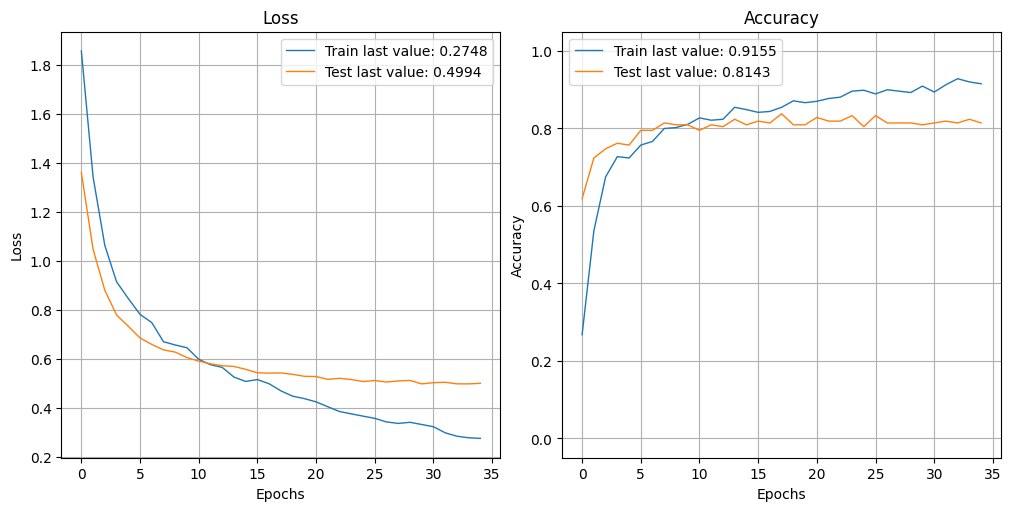

In [34]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [70]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

7/7 [==============================] - 26s 4s/step
[4 5 1 6 6 0 6 4 1 4 5 0 3 3 6 5 6 6 1 0 3 4 4 6 1 4 1 0 2 0 3 4 6 0 2 6 2
 3 6 4 0 1 3 2 1 5 6 6 4 5 0 4 5 4 5 2 0 6 6 1 2 6 6 5 5 3 2 0 4 5 6 2 5 5
 5 2 4 1 1 0 3 2 4 5 0 2 1 3 1 6 1 0 0 6 3 6 5 0 0 5 0 1 2 0 5 6 5 5 6 2 4
 2 1 2 2 5 5 5 0 5 0 3 0 1 3 5 5 1 5 4 3 6 4 1 6 3 1 5 2 3 1 4 1 6 4 2 2 6
 5 0 6 3 3 6 4 0 2 5 1 0 4 6 4 5 4 5 5 0 4 3 0 3 3 0 4 2 0 3 0 4 1 6 3 6 3
 1 1 1 6 6 2 4 5 1 3 5 1 6 2 4 2 4 1 0 2 0 4 0 1 0]

[4 5 1 6 6 4 6 4 4 0 5 0 3 0 6 5 6 6 1 0 3 4 0 6 1 4 1 3 5 0 6 4 6 0 2 6 2
 3 6 2 3 1 3 2 1 5 6 6 4 5 4 4 1 4 5 2 0 6 6 4 2 6 6 5 6 3 5 0 0 5 6 2 5 5
 5 2 4 1 1 0 3 2 4 1 0 2 1 3 1 6 1 4 0 6 3 6 5 0 0 5 0 1 2 3 5 6 5 5 6 1 0
 2 1 2 2 5 5 5 0 5 4 3 0 1 2 5 5 1 1 4 3 6 4 1 6 3 4 5 2 3 1 0 1 6 4 2 2 6
 5 4 6 3 3 6 0 0 2 5 1 0 0 6 4 5 4 5 3 0 4 3 0 3 3 0 4 2 0 3 0 0 0 6 3 6 5
 1 1 1 6 6 2 4 5 1 2 3 1 6 2 4 2 4 1 0 2 0 4 2 1 0]


In [87]:
from sklearn import cluster, metrics


In [88]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[24  0  1  3  5  0  0]
 [ 2 25  0  0  3  0  0]
 [ 1  1 20  1  0  2  0]
 [ 1  0  1 17  2  1  2]
 [ 6  0  2  1 21  0  0]
 [ 1  3  0  0  0 29  1]
 [ 0  0  0  0  0  0 34]]


In [89]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [90]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[24  0  1  3  5  0  0]
 [ 2 25  0  0  3  0  0]
 [ 1  1 20  1  0  2  0]
 [ 1  0  1 17  2  1  2]
 [ 6  0  2  1 21  0  0]
 [ 1  3  0  0  0 29  1]
 [ 0  0  0  0  0  0 34]]

              precision    recall  f1-score   support

           0       0.69      0.73      0.71        33
           1       0.86      0.83      0.85        30
           2       0.83      0.80      0.82        25
           3       0.77      0.71      0.74        24
           4       0.68      0.70      0.69        30
           5       0.91      0.85      0.88        34
           6       0.92      1.00      0.96        34

    accuracy                           0.81       210
   macro avg       0.81      0.80      0.80       210
weighted avg       0.81      0.81      0.81       210



## Approche avec data augmentation

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Créer une instance de l'augmentation de données
data_augmented = ImageDataGenerator(
    rotation_range=10,  # Rotation aléatoire de l'image dans la plage de -20 à 20 degrés
    width_shift_range=0.2,  # Décalage horizontal aléatoire de l'image dans la plage de -20% à 20% de la largeur
    height_shift_range=0.2,  # Décalage vertical aléatoire de l'image dans la plage de -20% à 20% de la hauteur
    shear_range=0.2,  # Cisaillement aléatoire de l'image dans la plage de -20 à 20 degrés
    zoom_range=0.2,  # Zoom aléatoire de l'image dans la plage de 80% à 120%
    horizontal_flip=True,  # Retournement horizontal aléatoire de l'image
    fill_mode='nearest'  # Mode de remplissage des pixels nouvellement créés après une transformation
)

# Ajuster l'augmentation de données aux données d'entraînement
data_augmented.fit(X_train)

# Entraînement du modèle avec augmentation de données
history_augmented = model1.fit(data_augmented.flow(X_train, y_train, batch_size=64),
                               steps_per_epoch=len(X_train) / 64,  # Nombre d'étapes par époque
                               epochs=50,
                               callbacks=callbacks_list,
                               validation_data=(X_val, y_val),
                               verbose=1)




Epoch 1/50
14/13 [================================] - ETA: -5s - loss: 0.4857 - accuracy: 0.8536
Epoch 1: val_loss did not improve from 0.49721
13/13 [==============================] - 111s 9s/step - loss: 0.4857 - accuracy: 0.8536 - val_loss: 0.5214 - val_accuracy: 0.8286
Epoch 2/50
14/13 [================================] - ETA: -5s - loss: 0.4651 - accuracy: 0.8583
Epoch 2: val_loss did not improve from 0.49721
13/13 [==============================] - 110s 9s/step - loss: 0.4651 - accuracy: 0.8583 - val_loss: 0.5100 - val_accuracy: 0.8238
Epoch 3/50
14/13 [================================] - ETA: -5s - loss: 0.4547 - accuracy: 0.8452
Epoch 3: val_loss improved from 0.49721 to 0.49343, saving model to .\model1_best_weights.h5
13/13 [==============================] - 111s 9s/step - loss: 0.4547 - accuracy: 0.8452 - val_loss: 0.4934 - val_accuracy: 0.8190
Epoch 4/50
14/13 [================================] - ETA: -5s - loss: 0.4527 - accuracy: 0.8524
Epoch 4: val_loss did not improve f

In [36]:
model1_save_path = "./model1_best_weights.h5"  # Définir le chemin de sauvegarde des poids du modèle

# Score de l'epoch optimal
model1.load_weights(model1_save_path)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy: {:.4f}".format(accuracy))



Validation Accuracy: 0.8333


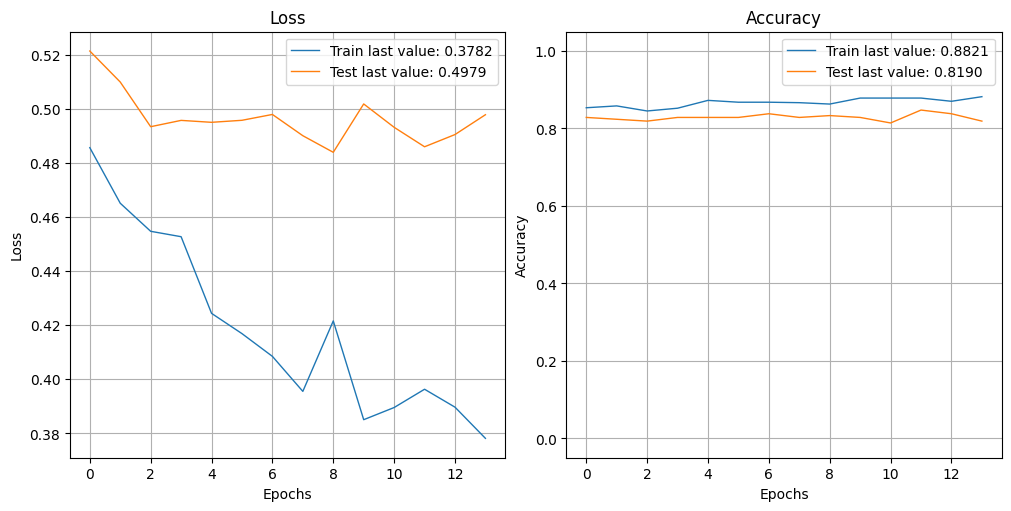

In [37]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history_augmented)
plot_history(history_augmented, path="standard.png")
plt.close()

## api

In [10]:
import requests

url = "https://edamam-food-and-grocery-database.p.rapidapi.com/api/food-database/v2/parser"

querystring = {"nutrition-type":"cooking","category[0]":"generic-foods","health[0]":"alcohol-free"}

headers = {
	"X-RapidAPI-Key": "53849f5854msha2775696c8f4d7cp1d638fjsnaf0d31a2942f",
	"X-RapidAPI-Host": "edamam-food-and-grocery-database.p.rapidapi.com"
}

response = requests.get(url, headers=headers, params=querystring)

print(response.json())

{'text': '', 'parsed': [], 'hints': [{'food': {'foodId': 'food_bwrgmmqau78xrdazxx79obeezumz', 'uri': 'http://www.edamam.com/ontologies/edamam.owl#Food_01001', 'label': 'Butter, Salted', 'knownAs': 'Butter, salted', 'nutrients': {'ENERC_KCAL': 717.0, 'PROCNT': 0.85, 'FAT': 81.1, 'CHOCDF': 0.06, 'FIBTG': 0.0}, 'category': 'Generic foods', 'categoryLabel': 'food', 'image': 'https://www.edamam.com/food-img/515/515af390107678fce1533a31ee4cc35b.jpeg'}, 'measures': [{'uri': 'http://www.edamam.com/ontologies/edamam.owl#Measure_tablespoon', 'label': 'Tablespoon', 'weight': 14.2}, {'uri': 'http://www.edamam.com/ontologies/edamam.owl#Measure_cup', 'label': 'Cup', 'weight': 227.0}, {'uri': 'http://www.edamam.com/ontologies/edamam.owl#Measure_stick', 'label': 'Stick', 'weight': 113.0}, {'uri': 'http://www.edamam.com/ontologies/edamam.owl#Measure_gram', 'label': 'Gram', 'weight': 1.0}, {'uri': 'http://www.edamam.com/ontologies/edamam.owl#Measure_ounce', 'label': 'Ounce', 'weight': 28.349523125}, {'u

In [12]:
import requests

url = "https://edamam-food-and-grocery-database.p.rapidapi.com/api/food-database/v2/parser"

querystring = {
    "nutrition-type": "cooking",
    "category[0]": "generic-foods",
    "health[0]": "alcohol-free",
    "ingr": "champagne"
}

headers = {
    "X-RapidAPI-Key": "53849f5854msha2775696c8f4d7cp1d638fjsnaf0d31a2942f",
    "X-RapidAPI-Host": "edamam-food-and-grocery-database.p.rapidapi.com"
}

response = requests.get(url, headers=headers, params=querystring)

print(response.json())


{'text': 'champagne', 'parsed': [{'food': {'foodId': 'food_a656mk2a5dmqb2adiamu6beihduu', 'uri': 'http://www.edamam.com/ontologies/edamam.owl#Food_table_white_wine', 'label': 'Champagne', 'knownAs': 'dry white wine', 'nutrients': {'ENERC_KCAL': 82.0, 'PROCNT': 0.07, 'FAT': 0.0, 'CHOCDF': 2.6, 'FIBTG': 0.0}, 'category': 'Generic foods', 'categoryLabel': 'food', 'image': 'https://www.edamam.com/food-img/a71/a718cf3c52add522128929f1f324d2ab.jpg'}}], 'hints': [{'food': {'foodId': 'food_a656mk2a5dmqb2adiamu6beihduu', 'uri': 'http://www.edamam.com/ontologies/edamam.owl#Food_table_white_wine', 'label': 'Champagne', 'knownAs': 'dry white wine', 'nutrients': {'ENERC_KCAL': 82.0, 'PROCNT': 0.07, 'FAT': 0.0, 'CHOCDF': 2.6, 'FIBTG': 0.0}, 'category': 'Generic foods', 'categoryLabel': 'food', 'image': 'https://www.edamam.com/food-img/a71/a718cf3c52add522128929f1f324d2ab.jpg'}, 'measures': [{'uri': 'http://www.edamam.com/ontologies/edamam.owl#Measure_unit', 'label': 'Whole', 'weight': 750.0}, {'uri'

In [28]:
import requests
import pandas as pd

url = "https://world.openfoodfacts.org/cgi/search.pl"

querystring = {
    "search_terms": "champagne",
    "page_size": "10",
    "json": "true"
}

response = requests.get(url, params=querystring)
data = response.json()

In [30]:
print(data.keys())


dict_keys(['count', 'page', 'page_count', 'page_size', 'products', 'skip'])


In [32]:
# Afficher les clés de la réponse
print("Clés de la réponse :", data.keys())
print("-------------------------")

# Afficher les premiers produits
products = data['products']
for product in products:
    print("foodId :", product.get('_id', ''))
    print("label :", product.get('product_name', ''))
    print("category :", product.get('categories', ''))
    print("foodContentsLabel :", product.get('ingredients_text', ''))
    print("image :", product.get('image_url', ''))
    print("-------------------------")

Clés de la réponse : dict_keys(['count', 'page', 'page_count', 'page_size', 'products', 'skip'])
-------------------------
foodId : 3292070010264
label : Betteraves rouges cultivées en Champagne
category : Aliments et boissons à base de végétaux, Aliments d'origine végétale, Aliments à base de fruits et de légumes, Légumes et dérivés, Betteraves
foodContentsLabel : Pois chiches 46%-purée de betterave rouge 38% - huile de coiza - purée de framboise 3%-fromage de chevre (contient lait) 2% - concentré de jus de citron-sel-graines de sesame dorées-graines de sesame noires-ail en poudre - conservateur: E202. Traces éventuelles de cereales contenant du gluten soia, crustaces œufs , moutarde poissons, molusques
image : https://images.openfoodfacts.org/images/products/329/207/001/0264/front_fr.13.400.jpg
-------------------------
foodId : 3039820510250
label : Vivien Paille Lentilles vertes le paquet de 500 g
category : Plant-based foods and beverages, Plant-based foods, Legumes and their prod

In [16]:


# Vérifier si la requête a réussi
if response.status_code == 200 and 'products' in data:
    products = data['products']

    # Créer une liste pour stocker les données des produits
    product_data = []

    # Parcourir les produits et extraire les informations nécessaires
    for product in products:
        foodId = product.get('_id', '')
        label = product.get('product_name', '')
        category = product.get('categories', '')
        foodContentsLabel = product.get('ingredients_text', '')
        image = product.get('image_url', '')

        # Ajouter les informations du produit à la liste
        product_data.append([foodId, label, category, foodContentsLabel, image])

    # Créer un DataFrame à partir des données des produits
    df = pd.DataFrame(product_data, columns=['foodId', 'label', 'category', 'foodContentsLabel', 'image'])

    # Enregistrer le DataFrame dans un fichier CSV
    df.to_csv('produits.csv', index=False)
    print("Extraction terminée. Les produits ont été enregistrés dans le fichier produits.csv.")
else:
    print("Erreur lors de la requête API.")


Extraction terminée. Les produits ont été enregistrés dans le fichier produits.csv.


In [26]:
products

[{'_id': '3292070010264',
  '_keywords': ['aliment',
   'atelier',
   'base',
   'betterave',
   'blini',
   'boisson',
   'champagne',
   'cultivee',
   'de',
   'derive',
   'en',
   'et',
   'france',
   'fruit',
   'legume',
   'origine',
   'rouge',
   'vegetale',
   'vegetaux'],
  'added_countries_tags': [],
  'additives_n': 1,
  'additives_old_n': 1,
  'additives_old_tags': ['en:e202'],
  'additives_original_tags': ['en:e202'],
  'additives_tags': ['en:e202'],
  'allergens': '',
  'allergens_from_ingredients': 'lait',
  'allergens_from_user': '(fr) ',
  'allergens_hierarchy': ['en:milk'],
  'allergens_tags': ['en:milk'],
  'amino_acids_tags': [],
  'brands': "l'atelier Blini",
  'brands_tags': ['l-atelier-blini'],
  'categories': "Aliments et boissons à base de végétaux, Aliments d'origine végétale, Aliments à base de fruits et de légumes, Légumes et dérivés, Betteraves",
  'categories_hierarchy': ['en:plant-based-foods-and-beverages',
   'en:plant-based-foods',
   'en:fruits-an

In [17]:
product = pd.read_csv('produits.csv')

In [18]:
product

,foodId,label,category,foodContentsLabel,image
0,3292070010264,Betteraves rouges cultivées en Champagne,"Aliments et boissons à base de végétaux, Alime...",Pois chiches 46%-purée de betterave rouge 38% ...,https://images.openfoodfacts.org/images/produc...
1,3039820510250,Vivien Paille Lentilles vertes le paquet de 500 g,"Plant-based foods and beverages, Plant-based f...",green lentils 100% origin france,https://images.openfoodfacts.org/images/produc...
2,3049610004104,Veuve Clicquot Champagne Ponsardin Brut,"Boissons, Boissons alcoolisées, Vins, Vins eff...",Champagne,https://images.openfoodfacts.org/images/produc...
3,3043700103715,Champagne brut Cordon Rouge,"Boissons, Boissons alcoolisées, Vins, Vins fra...",Contient des sulfites.,https://images.openfoodfacts.org/images/produc...
4,3114080034057,Champagne rosé,"Bebidas, Bebidas alcohólicas, Vinos, Vinos esp...",NaN,https://images.openfoodfacts.org/images/produc...
5,26011103,Champagne Veuve Durand,"Boissons, Boissons alcoolisées, Vins, Vins fra...","Cépages : Pinot Noir, Meunier, Chardonnay. Con...",https://images.openfoodfacts.org/images/produc...
6,3114080116050,Champagne Brut Premier,"Boissons, Boissons alcoolisées, Vins, Vins eff...",Contient des _sulfites_.,https://images.openfoodfacts.org/images/produc...
7,3596710335961,Miel de la Champagne,"Petit-déjeuners, Produits à tartiner, Produits...",Miel de la Champagne,https://images.openfoodfacts.org/images/produc...
8,4056489276845,Miel de luzerne de la champagne,"Petit-déjeuners,Produits à tartiner,Produits à...",NaN,https://images.openfoodfacts.org/images/produc...
9,3113841001000,Champagne Brut Majeur,"Boissons, Boissons alcoolisées, Vins, Vins fra...",Contient des _sulfites_,https://images.openfoodfacts.org/images/produc...


In [19]:
 product_data

[['3292070010264',
  'Betteraves rouges cultivées en Champagne',
  "Aliments et boissons à base de végétaux, Aliments d'origine végétale, Aliments à base de fruits et de légumes, Légumes et dérivés, Betteraves",
  'Pois chiches 46%-purée de betterave rouge 38% - huile de coiza - purée de framboise 3%-fromage de chevre (contient lait) 2% - concentré de jus de citron-sel-graines de sesame dorées-graines de sesame noires-ail en poudre - conservateur: E202. Traces éventuelles de cereales contenant du gluten soia, crustaces œufs , moutarde poissons, molusques',
  'https://images.openfoodfacts.org/images/products/329/207/001/0264/front_fr.13.400.jpg'],
 ['3039820510250',
  'Vivien Paille Lentilles vertes le paquet de 500 g',
  'Plant-based foods and beverages, Plant-based foods, Legumes and their products, Legumes, Seeds, Legume seeds, Pulses, Lentils, Green lentils, en:vegetables-based-foods',
  'green lentils 100% origin france',
  'https://images.openfoodfacts.org/images/products/303/982/

In [27]:
# Vérifier si la requête a réussi
if response.status_code == 200 and 'products' in data:
    products = data['products']

    # Vérifier si des produits sont présents
    if products:
        # Obtenir les clés spécifiques du premier produit
        keys = products[0].keys()
        print(keys)
    else:
        print("Aucun produit trouvé.")
else:
    print("Erreur lors de la requête API.")

dict_keys(['_id', '_keywords', 'added_countries_tags', 'additives_n', 'additives_old_n', 'additives_old_tags', 'additives_original_tags', 'additives_tags', 'allergens', 'allergens_from_ingredients', 'allergens_from_user', 'allergens_hierarchy', 'allergens_tags', 'amino_acids_tags', 'brands', 'brands_tags', 'categories', 'categories_hierarchy', 'categories_lc', 'categories_old', 'categories_properties', 'categories_properties_tags', 'categories_tags', 'checkers_tags', 'cities_tags', 'code', 'codes_tags', 'compared_to_category', 'complete', 'completed_t', 'completeness', 'correctors_tags', 'countries', 'countries_hierarchy', 'countries_tags', 'created_t', 'creator', 'data_quality_bugs_tags', 'data_quality_errors_tags', 'data_quality_info_tags', 'data_quality_tags', 'data_quality_warnings_tags', 'data_sources', 'data_sources_tags', 'ecoscore_data', 'ecoscore_grade', 'ecoscore_score', 'ecoscore_tags', 'editors_tags', 'emb_codes', 'emb_codes_tags', 'entry_dates_tags', 'food_groups', 'food_g